# References

https://analyticsindiamag.com/reinforcement-learning-policy/

https://leimao.github.io/blog/RL-On-Policy-VS-Off-Policy/

# Imports

In [13]:
import numpy as np
import copy
from gym import Env
import datetime
import sys
import itertools
import random
import matplotlib.pyplot as plt

# Environment

In [3]:
class FrozenLake(Env):
    
    def __init__(self,studentNum:int=256, nonStationary = False):
        self.studentNum = studentNum
        self.nonStationary = nonStationary
        
        np.random.seed(self.studentNum)
        self.beginMap = make_map(self.studentNum) #*2
        self.beginMap[self.beginMap>1] = 1
        self.endMap = make_map(self.studentNum + 100)
        
        self.changeDir = self.endMap - self.beginMap
        self.changeDir *= 1/11000

        self.fixedMap = self.beginMap

        np.random.seed(datetime.datetime.now().microsecond)
        
        self.map = copy.deepcopy(self.fixedMap)
        self.time = 0
        self.reset()

        
    def reset(self):
        self.NSreset()
        if not self.nonStationary:
            self.map = copy.deepcopy(self.fixedMap)
            self.time = 0

        return self.state

    
    def NSreset(self):
        self.time += 1
        self.map += self.changeDir

        self.map[self.map>0.95]=0.95
        self.map[self.map<0.0]=0.0

        self.state = (0,0)
        self.done = False
        return self.state
    
    
    def states_transitions(self, state, action):
        x = state[0]
        y = state[1]
        states = np.array([[x,y-1], [x,y+1], [x-1 ,y], [x+1,y] ])


        if action == UP:
            selected = states[2]
        if action == DOWN:
            selected = states[3]
        if action == RIGHT:
            selected = states[1]
        if action == LEFT:
            selected = states[0]

        zero = np.zeros((4,2)).astype(int)
        three = (3 * np.ones((4,2))).astype(int)
        output = np.maximum(np.minimum(states, three),zero)
        output, indices = np.unique(output, axis = 0, return_counts= True)

        
        selected = np.maximum(np.minimum(selected, three[0]), zero[0])
        probs = indices * 0.025
        probs[np.argmax(np.sum(selected == output, axis = 1))] += 0.9

        return list(zip(output[:,0],output[:,1])), probs
    
    
    def possible_consequences(self,action:int,state_now=None):

        if state_now==None:
            state_now = self.state

        state = [state_now[0],state_now[1]]
        states, probs = self.states_transitions(state, action)
        aa = np.array(states) 
        fail_probs = self.map[(aa[:,0]),(aa[:,1])]
        dones = np.sum(aa == 3, axis = 1) == 2
        return states, probs, fail_probs,dones
    
    
    def step(self, a:int):
        if not (a in range(4)):
            raise Exception("action is not available!!!")
        
        states, probs, fail_probs,dones = self.possible_consequences(a)
        
        next_idx = np.random.choice(np.arange(len(states)), p = probs)
        next_state = states[next_idx]
        self.state = tuple(next_state)
        
        self.done = dones[next_idx]

        r = -1

        if self.done:
            r += 60
        elif np.random.rand()< fail_probs[next_idx]:
            r -= 15
            self.done = True

        return (self.state, r, self.done, {})

    
    def render(self,state=None):
        if state == None:
            state = self.state

        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                if (i,j) == state:
                    out += "\033[44m{:.3f}\033[0m | ".format(self.map[i,j])
                else :
                    out += "{:.3f} | ".format(self.map[i,j])

        out += "\n------------------------------"
        print(out)

        
    def environment_states(self):
        env_states = []
        for state_index in range(16):
            s0 = state_index % 4
            s1 = state_index//4
            env_states.append((s0,s1))
        return env_states

        
def set_max_min(var,maximum,minimum):
    return min(max(var,minimum),maximum)


def make_map(studentNum):
    np.random.seed(studentNum)  
    move = np.zeros(6)
    idx = np.random.choice(range(6),size=3,replace=False)
    move[idx] = 1

    point = [0,0]
    lowprobs = [tuple(point)]

    for m in move:
        if m:
            point[0] += 1
        else:
            point[1] += 1
        lowprobs.append(tuple(point))
    
    map = np.random.rand(4,4)
    idx = np.array(lowprobs)

    map[idx[:,0],idx[:,1]] = 0.001 
    map[0,0] = 0.0
    map[3,3] = 0.0 

    return map

## Your Student ID

In [4]:
STUDENT_NUM = 99722153

# HyperParameters

In [5]:
#%% allowed actions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

ACTIONS = [LEFT,DOWN,RIGHT,UP]

#%% hyperparameters
EPISODES = 10000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9

## Map of environment

In [6]:
environment = FrozenLake(studentNum=STUDENT_NUM)

print("Environment with fail probabilities :")
environment.render()


Environment with fail probabilities :

------------------------------
| 0.000 | 0.001 | 0.293 | 0.680 | 
------------------------------
| 0.736 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.693 | 0.892 | 0.218 | 0.001 | 
------------------------------
| 0.465 | 0.918 | 0.318 | 0.000 | 
------------------------------


## <h2><font color=indigo> Agent Implementation
Implement your q-learning (off-policy TD) agent here. You need to utilize the step function provided in the Environment class to interact with frozen lake environment.

In [32]:
class Q_Learning:
    
    def __init__(self, id, environment, discount , learning_rate = 0.1 , epsilon = 0.1 ,episodes=10000):
        
        self.id = id
        
        self.map_size = 16
        self.map_y = 4
        
        self.environment = environment
        self.discount = discount
        self.episodes = episodes
        self.learning_rate = learning_rate
        self.environment = environment
        self.epsilon = epsilon
        self.n_actions = 4
        self.Q_values = np.zeros((self.map_size,self.n_actions))
        
    
    # convert states into 0 to max_size number (15 in this example)
    def state_serializer(self, state):
        return self.map_y*state[0] + state[1]
    
    
    # take a epsilon greedy action
    def take_action(self, current_state):
        current_state_serial = self.state_serializer(current_state)
        
        random_number = np.random.random()
        if random_number < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = np.argmax(self.Q_values[current_state_serial])
            
        return action
    
    
    # update Q values with the Q learning algorithm equation
    def update_Q_value(self, action, current_state, next_state, reward):
        current_state_serial = self.state_serializer(current_state)
        next_state_serial = self.state_serializer(next_state)
        
        current_Q_value = self.Q_values[current_state_serial][action]
        
        max_Q_value_next_state = self.Q_values[next_state_serial][np.argmax(self.Q_values[next_state_serial])]
        
        new_Q_value = current_Q_value + self.learning_rate * (reward + (self.discount * max_Q_value_next_state) - current_Q_value)
                
        self.Q_values[current_state_serial][action] = new_Q_value
        
    
    # train the agent and return rewards for the given number of episodes
    def train(self):
        rewards = np.zeros(self.episodes)
        
        for episode in range(self.episodes):
            reward_sum = 0
            current_state = self.environment.reset()
            
            if episode % 1000 == 0:
                print("episode: ", episode)

            while True :

                bestAction = self.take_action(current_state)
                next_state, reward, done, _ = environment.step(bestAction)
                self.update_Q_value(bestAction, current_state, next_state, reward)
                reward_sum += reward
                current_state = next_state         

                if done:
                    break
            rewards[episode] = reward_sum
            
        return rewards
       

    # print and return policy (greedy policy based on Q values)    
    def print_policy(self):
        ACTIONS = ["LEFT","DOWN","RIGHT","UP"]

        policy = []
        policy_str = []
        
        for i in range(len(self.Q_values)-1):
            best_Q_value_index = np.argmax(self.Q_values[i])
            policy.append(best_Q_value_index)
            action = ACTIONS[best_Q_value_index]
            policy_str.append(action)
            
            
            print(i)
            print(self.Q_values[i]) 
            print("Best Action: ", action)
            print("------------------------------------------------")
            
        return policy, policy_str

## <h2><font color=indigo> Q Values
Return the Q values that your agent learns in here:

In [8]:
agent = Q_Learning('TohidAbedini', environment, 0.9 , learning_rate = 0.5 , epsilon = 0.1 ,episodes= 10000)
rewards = agent.train()

episode:  0
episode:  1000
episode:  2000
episode:  3000
episode:  4000
episode:  5000
episode:  6000
episode:  7000
episode:  8000
episode:  9000


In [9]:
Q = agent.Q_values
print(Q)

[[ 13.70515567   7.37033088  28.10390392  13.14911339]
 [ 24.42368561  32.24413359  25.34301237  24.30341345]
 [ 21.11669674  36.59580701  22.99295873  20.08096529]
 [ 21.70413141  38.81742183  21.48290076  18.8321704 ]
 [ -2.25152193 -16.12164378  -3.66850854  21.97106096]
 [  3.68028756  28.48612088  37.3236556   24.62394401]
 [ 28.22934168  38.40246758  43.1850065   28.3694297 ]
 [ 37.57580764  47.52399965  27.30996484  17.40141147]
 [ -8.25        -0.75        -8.11924869  -5.31431566]
 [ -8.          -3.62616841  44.74685149   0.        ]
 [ 25.09283286  31.87058496  47.52785462  37.46202284]
 [ 39.36525935  55.66096984  51.70663689  45.31168069]
 [ -0.5         -0.5         -0.5         -8.3375    ]
 [ 14.6570507    0.           0.           0.        ]
 [ -1.50306334  19.81168703  27.24205587  32.34964151]
 [  0.           0.           0.           0.        ]]


In [10]:
environment.render()


------------------------------
| 0.000 | 0.001 | 0.293 | 0.680 | 
------------------------------
| 0.736 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.693 | 0.892 | 0.218 | 0.001 | 
------------------------------
| 0.465 | 0.918 | 0.318 | 0.000 | 
------------------------------


## <h2><font color=blue> Rewards
Plot average cumulative rewards rewards

In [29]:
# cumulative sum of a given array
def array_to_cumulative(array):
    out = np.zeros(len(array))
    for i in range(len(array)):
        if i == 0 :
            out[i] = array[0]
        else:
            out[i] = array[:i].mean()
    return out


# plot rewatds
def plot_rewards(rewards, to_cum=True, limit=False, bottom=-3, top=8, ylabel="Reward of episode"):
    plt.figure(figsize=(15, 8))
    xticks = len(rewards)
    
    if to_cum:
        rewards = array_to_cumulative(rewards)
        
    plt.plot(range(1,xticks+1), rewards)
    if limit:
        plt.ylim(top=top)
        plt.ylim(bottom=bottom)
            
    plt.xlabel("Episodes")
    plt.ylabel(ylabel)

    plt.show()

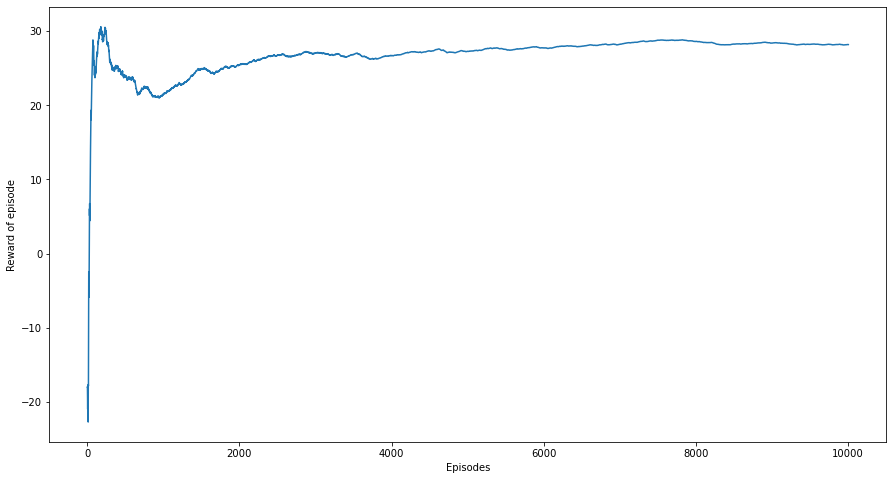

In [30]:
plot_rewards(rewards)

## <h2><font color=darkcyan> Policy
Return the optimal policy that your agent learns in here:

In [31]:
policy, policy_str = agent.print_policy()

0
[13.70515567  7.37033088 28.10390392 13.14911339]
Best Action:  RIGHT
------------------------------------------------
1
[24.42368561 32.24413359 25.34301237 24.30341345]
Best Action:  DOWN
------------------------------------------------
2
[21.11669674 36.59580701 22.99295873 20.08096529]
Best Action:  DOWN
------------------------------------------------
3
[21.70413141 38.81742183 21.48290076 18.8321704 ]
Best Action:  DOWN
------------------------------------------------
4
[ -2.25152193 -16.12164378  -3.66850854  21.97106096]
Best Action:  UP
------------------------------------------------
5
[ 3.68028756 28.48612088 37.3236556  24.62394401]
Best Action:  RIGHT
------------------------------------------------
6
[28.22934168 38.40246758 43.1850065  28.3694297 ]
Best Action:  RIGHT
------------------------------------------------
7
[37.57580764 47.52399965 27.30996484 17.40141147]
Best Action:  DOWN
------------------------------------------------
8
[-8.25       -0.75       -8.11924